# TCNN Classifier

In [3]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import sys
import numpy as np
import random
from sklearn.metrics import accuracy_score

sys.path.append('../scripts')
import ml_helper
import ml_evaluation

In [128]:
data_path = '../data'

Code inspiered:

https://de.mathworks.com/help/deeplearning/ug/sequence-to-sequence-classification-using-1-d-convolutions.html

References:

- [1] Bai, Shaojie, J. Zico Kolter, and Vladlen Koltun. “An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling.” Preprint, submitted April 19, 2018. https://arxiv.org/abs/1803.01271.

- [2] Oord, Aaron van den, Sander Dieleman, Heiga Zen, Karen Simonyan, Oriol Vinyals, Alex Graves, Nal Kalchbrenner, Andrew Senior, and Koray Kavukcuoglu. “WaveNet: A Generative Model for Raw Audio.” Preprint, submitted September 12, 2016. https://arxiv.org/abs/1609.03499.

- [3] Tompson, Jonathan, Ross Goroshin, Arjun Jain, Yann LeCun, and Christoph Bregler. “Efficient Object Localization Using Convolutional Networks.” 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 648–56. https://doi.org/10.1109/CVPR.2015.7298664.


In [129]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [130]:
SEED = 42
def set_seed(SEED=SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
set_seed()

### Creating the Network

In [5]:
class TemporalConvNet(nn.Module):
    def __init__(self, num_features: int, num_classes: int, num_filters: int, filter_size: int, 
                 dropout_factor: float, num_blocks: int, parallel_layer: bool) -> None:
        """
        This function initializes the TemporalConvNet model
        ------
        num_features: number of features in the input
        num_classes: number of classes to predict
        num_filters: number of filters in each convolutional layer
        filter_size: size of the convolutional filter
        dropout_factor: dropout factor
        num_blocks: number of blocks of dilated convolutions
        parallel_layer: whether to add the parallel layer
        """
        super(TemporalConvNet, self).__init__()
        self.num_blocks = num_blocks
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.dropout_factor = dropout_factor
        self.parallel_layer = parallel_layer
        if self.parallel_layer:
            self.optional_layer = nn.Conv1d(num_features, num_filters, kernel_size=1)

        self.layers = nn.ModuleList()
        # Input layer
        self.layers.append(nn.Conv1d(num_features, num_filters, kernel_size=1))
        self.layers.append(nn.BatchNorm1d(num_filters))
        
        # Dilated convolutional blocks
        for i in range(num_blocks):
            dilation = 2 ** i
            # this function defines the padding and therefore teh sequence length
            pad = (filter_size - 1) * dilation // 2 
            # TODO: fix for even filter size
            self.layers.append(nn.Conv1d(num_filters, num_filters, kernel_size=filter_size, dilation=dilation, padding=pad))
            self.layers.append(nn.BatchNorm1d(num_filters))
            # if last than not dropout
            if i != num_blocks - 1:
                self.layers.append(nn.Dropout(dropout_factor))

        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout_factor))

        self.layers.append(nn.Softmax(dim=1))

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        This function defines the forward pass of the model
        ------
        x: input tensor of shape (batch_size, num_features, sequence_length)
        ------
        returns: output tensor of shape (batch_size, num_classes, sequence_length)
        """
        x_init = x.permute(0, 2, 1)
        x = x_init.clone()
        for layer in self.layers:
            x = layer(x)
        # skipped all other connections and add it at the end
        if self.parallel_layer:
            x_optional = self.optional_layer(x_init)
            x = x + x_optional

        return x

In [132]:
def train(model, training_data: DataLoader, valid_data: DataLoader, epochs: int, optimizer: optim.Optimizer, loss_fn: nn.Module) -> None:
    """
    Trains the model for the specified number of epochs
    ------
    model: TCN model
    training_data: DataLoader with the training data
    valid_data: DataLoader with the valid data
    epochs: number of epochs to train the model
    optimizer: optimizer to use
    loss_fn: loss function to use
    ------
    Returns the training losses and accuracies
    """
    trainings_losses = []
    trainings_accuracies = []
    valid_avg_accs = []

    model.to(device)
    model.train()

    for epoch in range(epochs):
        accuracies = []
        losses = []

        # Training loop
        for inputs, labels in training_data:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_fn(outputs.squeeze(), labels.squeeze().long())
            loss.backward()
            optimizer.step()

            # get accuracy
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.view(-1)
            labels = labels.view(-1)
            acc = accuracy_score(labels.cpu(), predicted.cpu())
            accuracies.append(acc)

            losses.append(loss.item())
        
        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient computation
            valid_accs = []
            for valid_in, valid_labels in valid_data:
                valid_in = valid_in.to(device)
                valid_labels = valid_labels.to(device)

                valid_out = model(valid_in)

                # get accuracy
                _, valid_pred = torch.max(valid_out, 1)
                valid_pred = valid_pred.view(-1)
                valid_labels = valid_labels.view(-1)
                valid_acc = accuracy_score(valid_labels.cpu(), valid_pred.cpu())
                valid_accs.append(valid_acc)
        
        model.train()  # Set the model back to training mode

        epoch_loss = np.mean(losses)
        epoch_acc = np.mean(accuracies)
        epoch_valid_acc = np.mean(valid_accs)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {round(epoch_loss, 3)}, accuracy: {round(epoch_acc, 3)}, valid acc: {round(epoch_valid_acc, 3)}')

        trainings_losses.append(epoch_loss)
        trainings_accuracies.append(epoch_acc)
        valid_avg_accs.append(epoch_valid_acc)


    return trainings_losses, trainings_accuracies, valid_avg_accs

In [133]:
def evaluate_model(model, device, test_loader: DataLoader) -> list:
    """
    This function evaluates the model on the test data
    ------
    model: model to evaluate
    test_loader: DataLoader with the test data
    ------
    returns: list with the predictions and labels
    """
    model.eval()  # Set the model to evaluation mode
    accuracies = []

    with torch.no_grad():
        for input_data, labels in test_loader:

            input_data = input_data.to(device)
            labels = labels.to(device)

            labels = labels.view(-1)

            # Forward pass
            outputs = model(input_data)
            
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.view(-1)

            # Compute custom metrics
            accuracy = accuracy_score(predicted.cpu(), labels.cpu())
            accuracies.append(accuracy)

    # Compute average accuracy
    
    return predicted, labels, accuracies

### Data Preparation

In [1]:
# Data preparation
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]
organism = organisms[2]
#"Homo.Sapiens"  "Drosophila.Melanogaster"  "E.Coli"
min_length = None
max_length = 500
one_hot = True

SPEEDS_ADDED = False
BATCH_SIZE = 32

In [135]:
train_dataset = ml_helper.CodonDataset(organism, "train", min_length, max_length, add_speeds=SPEEDS_ADDED, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge train_dataset: {len(train_dataset)}")
test_dataset = ml_helper.CodonDataset(organism, "test", min_length, max_length, add_speeds=SPEEDS_ADDED, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge test_dataset: {len(test_dataset)}")
valid_dataset = ml_helper.CodonDataset(organism, "valid", min_length, max_length, add_speeds=SPEEDS_ADDED, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge valid_dataset: {len(valid_dataset)}")

Länge train_dataset: 140711
Länge test_dataset: 17489
Länge valid_dataset: 17784


In [136]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Hyperparameters and Model Initialization

In [137]:
# Hyperparameters
num_features = len(ml_helper.amino_acids)
num_classes = len(ml_helper.codons)  # number of codons (output classes)

num_filters = 128 #64
filter_size = 5#3  # NOTE: filter size must be unequal like: 3,5,9,...
dropout_factor = 0.008 #0.005
num_blocks = 5#2
parallel_layer = True

# Model
tcnModel = TemporalConvNet(num_features, num_classes, num_filters, filter_size, 
                        dropout_factor, num_blocks, parallel_layer)
print(tcnModel)

# Train variables
NUM_EPOCHS = 100
learing_rate = 0.001 # 0.001

#criterion = nn.CrossEntropyLoss(ignore_index=64)
criterion = nn.CrossEntropyLoss(ignore_index=ml_helper.codons_to_integer['___'])
optimizer = optim.Adam(tcnModel.parameters(), lr=learing_rate)

TemporalConvNet(
  (optional_layer): Conv1d(22, 128, kernel_size=(1,), stride=(1,))
  (layers): ModuleList(
    (0): Conv1d(22, 128, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.008, inplace=False)
    (5): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,))
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.008, inplace=False)
    (8): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(4,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.008, inplace=False)
    (11): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(16,), dilation=(8,))
    (12): BatchNorm1d

### Start Training

In [138]:
#trainings_losses, trainings_accuracies, valid_accs = train(tcnModel, train_loader, valid_loader, NUM_EPOCHS, optimizer, criterion)

/home/mkuehn/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch [1/100], Loss: 1.811, accuracy: 0.376, valid acc: 0.389
Epoch [2/100], Loss: 1.075, accuracy: 0.387, valid acc: 0.391
Epoch [3/100], Loss: 1.05, accuracy: 0.39, valid acc: 0.394
Epoch [4/100], Loss: 1.043, accuracy: 0.393, valid acc: 0.397
Epoch [5/100], Loss: 1.04, accuracy: 0.396, valid acc: 0.398
Epoch [6/100], Loss: 1.038, accuracy: 0.398, valid acc: 0.4
Epoch [7/100], Loss: 1.036, accuracy: 0.399, valid acc: 0.402
Epoch [8/100], Loss: 1.034, accuracy: 0.401, valid acc: 0.403
Epoch [9/100], Loss: 1.033, accuracy: 0.402, valid acc: 0.404
Epoch [10/100], Loss: 1.031, accuracy: 0.403, valid acc: 0.405
Epoch [11/100], Loss: 1.03, accuracy: 0.404, valid acc: 0.405
Epoch [12/100], Loss: 1.03, accuracy: 0.405, valid acc: 0.407
Epoch [13/100], Loss: 1.029, accuracy: 0.406, valid acc: 0.407
Epoch [14/100], Loss: 1.028, accuracy: 0.406, valid acc: 0.408
Epoch [15/100], Loss: 1.027, accuracy: 0.407, valid acc: 0.409
Epoch [16/100], Loss: 1.027, accuracy: 0.407, valid acc: 0.409
Epoch [1

### Save the model

In [139]:
#ml_helper.save_model(tcnModel, f'tcn_valid_acc_{round(round(valid_accs[-1],2) * 100)}', organism)

Model saved as 20240609020834_tcn_valid_acc_42.pt


### Load the model

In [7]:
#ml_helper.load_model(f'tcn', organism)

### Evaluation of the model

In [141]:
predicted, labels, accuracies = evaluate_model(tcnModel, device, test_loader)

#### Get codon names and associated amino acids

In [142]:
predicted = predicted.cpu().numpy()
labels = labels.cpu().numpy()

predicted, labels = ml_evaluation.filter_padding(predicted, labels, filter_value=64)

predicted_codon_names =  ml_evaluation.codon_to_name(predicted)
labels_codon_names =  ml_evaluation.codon_to_name(labels)

predicted_aa =  ml_evaluation.translate_codons(predicted_codon_names)
labels_aa =  ml_evaluation.translate_codons(labels_codon_names)

ml_evaluation.get_unique_pred_classes(predicted_codon_names, labels_codon_names)
ml_evaluation.print_unique_elements(predicted_aa, labels_aa)

predicted different classes:  54 out of: 61
predicted following classes:  {'AAC', 'TGG', 'GAT', 'GAG', 'TGC', 'AAA', 'AAG', 'ACA', 'GAA', 'TGT', 'AGT', 'GGG', 'TAC', 'CCC', 'TTG', 'ATG', 'CAC', 'AGC', 'GCA', 'GCT', 'CAA', 'CGT', 'CCA', 'CGA', 'CTC', 'GTT', 'GTC', 'TTC', 'ATA', 'AGG', 'GTG', 'GGA', 'TCT', 'CTT', 'ATT', 'TCA', 'ATC', 'ACT', 'AGA', 'AAT', 'CCT', 'CGG', 'GGT', 'CTG', 'CAG', 'TAT', 'CAT', 'CGC', 'TTT', 'TCC', 'GGC', 'GAC', 'GCC', 'ACC'}
predicted different amino acids:  20 out of: 20


#### Accuracies

In [143]:
# Calculate Accuracy of amino 
avg_accuracy = np.mean(accuracies)
accuracy_aa = accuracy_score(labels_aa, predicted_aa)

print('-' * 100)
print(f'Average accuracy: {avg_accuracy}')
print(f'Accuracy of amino acids: {accuracy_aa}')
print('-' * 100)

----------------------------------------------------------------------------------------------------
Average accuracy: 0.4171435759620333
Accuracy of amino acids: 1.0
----------------------------------------------------------------------------------------------------


## Plots

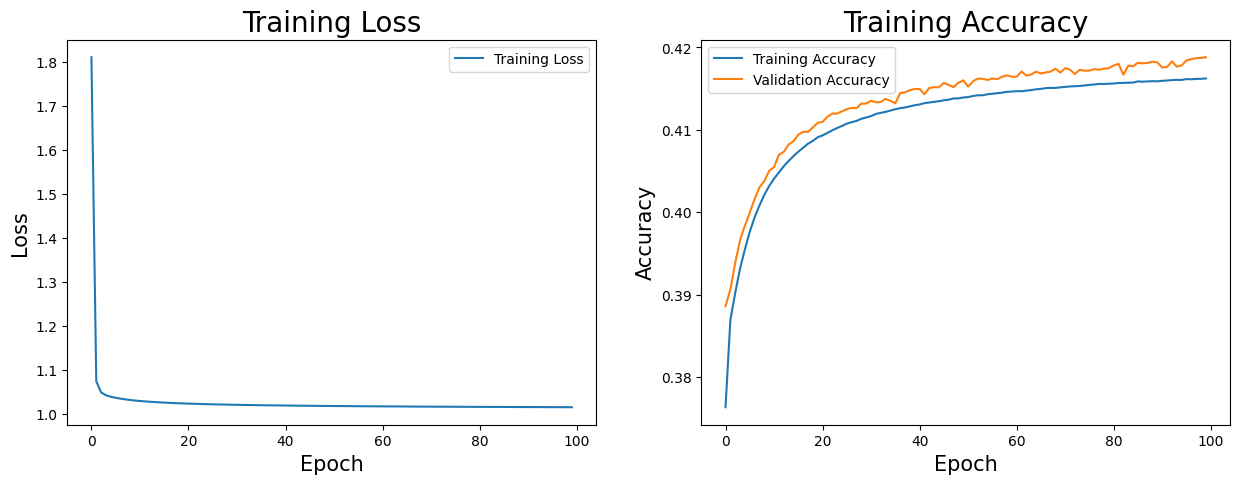

In [144]:
# check if training losses and accuracies is defined
if 'trainings_losses' in locals() and 'trainings_accuracies' in locals():
    # plot of training loss and accuracy
    plt = ml_evaluation.plot_training(trainings_losses, trainings_accuracies, valid_accs)
    plt.show()
else:
    print("No training losses and accuracies available")